<a href="https://colab.research.google.com/github/carloscarvajal1cc/Basketball_TipOffs/blob/master/Tip_Offs_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basketball Tip-offs prediction model with Deep Learning and Data Mining

The following code present an approach to evaluate how good each player is at winning tip-offs, with a dataset from the NBA basketball in the 2017-18 season.

In order to achieve a good prediction several models will be built and compared and one will be chosen according to the best accuracy in predicting weather a player will win or loose a tip-off.

First, all the relevant libraries, along with the previously transformed in excel dataset will be loaded into the enviroment. 

In [65]:
!pip install tensorflow

## Importing the data set

In [1]:
import numpy as np
import pandas as pd
import io
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import  BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from time import time
import logging
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVC
import matplotlib.pyplot as plt


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score


from google.colab import files
uploaded = files.upload()
Data = pd.read_csv(io.StringIO(uploaded['Basketball1.csv'].decode('utf-8')))

Using TensorFlow backend.


Saving Basketball1.csv to Basketball1.csv


Thus, by using pandas the dataset can be observed as follow:

In [2]:
Data.head()


,Home Player Win,Home Player Country,Away Player Country,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs)
0,0,NNN,NNN,43025,18,11,99,38,87,290,20,76,191
1,0,NNN,NNN,43025,-18,-11,-99,20,76,191,38,87,290
2,0,USA,Dominican Republic,43025,-2,0,6,30,82,251,32,82,245
3,0,Russia,Switzerland,43025,10,1,30,34,83,270,24,82,240
4,0,USA,USA,43026,-7,0,14,25,83,279,32,83,265


In [0]:
copyofdata = Data.copy() 

## Preprocessing the data

As all the models that will be built in this code work with numeric attributes, it is necessary to hot encode those attributes that contain categorical values, such as Home Player Country and Away Player Country.

In addition, the two first rows have been created as fake rows, in order to include the min and max observations of all players to perform normalization.

This rows will be later deleted.

In [19]:
columns = Data.columns

Data.head()

,Home Player Win,Home Player Country,Away Player Country,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs)
0,0,NNN,NNN,43025,18,11,99,38,87,290,20,76,191
1,0,NNN,NNN,43025,-18,-11,-99,20,76,191,38,87,290
2,0,USA,Dominican Republic,43025,-2,0,6,30,82,251,32,82,245
3,0,Russia,Switzerland,43025,10,1,30,34,83,270,24,82,240
4,0,USA,USA,43026,-7,0,14,25,83,279,32,83,265


In [20]:
# Converting the home countries to binary with hot encode

Data = pd.get_dummies(Data, columns=["Home Player Country"])

Data = pd.get_dummies(Data, columns=["Away Player Country"])

columns = Data.columns

Data.head()

,Home Player Win,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs),Home Player Country_Australia,Home Player Country_Bosnia and Herzegovina,Home Player Country_Brazil,Home Player Country_Cameroon,Home Player Country_Canada,Home Player Country_Croatia,Home Player Country_Democratic Republic of Congo,Home Player Country_Dominican Republic,Home Player Country_France,Home Player Country_Germany,Home Player Country_Greece,Home Player Country_Haiti,Home Player Country_Latvia,Home Player Country_Lithuania,Home Player Country_Montenegro,Home Player Country_NNN,Home Player Country_New Zealand,Home Player Country_Poland,Home Player Country_Russia,Home Player Country_Serbia,Home Player Country_South Sudan,Home Player Country_Spain,Home Player Country_Switzerland,Home Player Country_USA,Home Player Country_Ukraine,Away Player Country_Australia,Away Player Country_Bosnia and Herzegovina,Away Player Country_Brazil,Away Player Country_Cameroon,Away Player Country_Canada,Away Player Country_Croatia,Away Player Country_Democratic Republic of Congo,Away Player Country_Dominican Republic,Away Player Country_France,Away Player Country_Germany,Away Player Country_Greece,Away Player Country_Haiti,Away Player Country_Israel,Away Player Country_Latvia,Away Player Country_Lithuania,Away Player Country_Montenegro,Away Player Country_NBA,Away Player Country_NNN,Away Player Country_New Zealand,Away Player Country_Poland,Away Player Country_Russia,Away Player Country_Serbia,Away Player Country_South Sudan,Away Player Country_Spain,Away Player Country_Switzerland,Away Player Country_Tunisia,Away Player Country_USA,Away Player Country_Ukraine
0,0,43025,18,11,99,38,87,290,20,76,191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,43025,-18,-11,-99,20,76,191,38,87,290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,43025,-2,0,6,30,82,251,32,82,245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,43025,10,1,30,34,83,270,24,82,240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,43026,-7,0,14,25,83,279,32,83,265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


It is also a good practice to normilize the data, so all values are trasformed to a number in a range of 0 and 1.

In [22]:
# Normalizing data


# Applying the minmax normalization.
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(Data.iloc[:,:])


x_scaled.shape

(1293, 64)

In [23]:
Data = pd.DataFrame(x_scaled)
Data.columns = columns[:]

Data.head()



,Home Player Win,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs),Home Player Country_Australia,Home Player Country_Bosnia and Herzegovina,Home Player Country_Brazil,Home Player Country_Cameroon,Home Player Country_Canada,Home Player Country_Croatia,Home Player Country_Democratic Republic of Congo,Home Player Country_Dominican Republic,Home Player Country_France,Home Player Country_Germany,Home Player Country_Greece,Home Player Country_Haiti,Home Player Country_Latvia,Home Player Country_Lithuania,Home Player Country_Montenegro,Home Player Country_NNN,Home Player Country_New Zealand,Home Player Country_Poland,Home Player Country_Russia,Home Player Country_Serbia,Home Player Country_South Sudan,Home Player Country_Spain,Home Player Country_Switzerland,Home Player Country_USA,Home Player Country_Ukraine,Away Player Country_Australia,Away Player Country_Bosnia and Herzegovina,Away Player Country_Brazil,Away Player Country_Cameroon,Away Player Country_Canada,Away Player Country_Croatia,Away Player Country_Democratic Republic of Congo,Away Player Country_Dominican Republic,Away Player Country_France,Away Player Country_Germany,Away Player Country_Greece,Away Player Country_Haiti,Away Player Country_Israel,Away Player Country_Latvia,Away Player Country_Lithuania,Away Player Country_Montenegro,Away Player Country_NBA,Away Player Country_NNN,Away Player Country_New Zealand,Away Player Country_Poland,Away Player Country_Russia,Away Player Country_Serbia,Away Player Country_South Sudan,Away Player Country_Spain,Away Player Country_Switzerland,Away Player Country_Tunisia,Away Player Country_USA,Away Player Country_Ukraine
0,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.444444,0.500000,0.530303,0.555556,0.545455,0.606061,0.666667,0.545455,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.777778,0.545455,0.651515,0.777778,0.636364,0.797980,0.222222,0.545455,0.494949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.004274,0.305556,0.500000,0.570707,0.277778,0.636364,0.888889,0.666667,0.636364,0.747475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
#Removing the two fake rows created  and columns in excel with min and max.

# Dropping columns that were not in the model:

Data = Data.drop(['Home Player Country_NNN', 'Away Player Country_NNN'], axis=1)

Data = Data.drop([0,1], axis=0)

Data.head()



,Home Player Win,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs),Home Player Country_Australia,Home Player Country_Bosnia and Herzegovina,Home Player Country_Brazil,Home Player Country_Cameroon,Home Player Country_Canada,Home Player Country_Croatia,Home Player Country_Democratic Republic of Congo,Home Player Country_Dominican Republic,Home Player Country_France,Home Player Country_Germany,Home Player Country_Greece,Home Player Country_Haiti,Home Player Country_Latvia,Home Player Country_Lithuania,Home Player Country_Montenegro,Home Player Country_New Zealand,Home Player Country_Poland,Home Player Country_Russia,Home Player Country_Serbia,Home Player Country_South Sudan,Home Player Country_Spain,Home Player Country_Switzerland,Home Player Country_USA,Home Player Country_Ukraine,Away Player Country_Australia,Away Player Country_Bosnia and Herzegovina,Away Player Country_Brazil,Away Player Country_Cameroon,Away Player Country_Canada,Away Player Country_Croatia,Away Player Country_Democratic Republic of Congo,Away Player Country_Dominican Republic,Away Player Country_France,Away Player Country_Germany,Away Player Country_Greece,Away Player Country_Haiti,Away Player Country_Israel,Away Player Country_Latvia,Away Player Country_Lithuania,Away Player Country_Montenegro,Away Player Country_NBA,Away Player Country_New Zealand,Away Player Country_Poland,Away Player Country_Russia,Away Player Country_Serbia,Away Player Country_South Sudan,Away Player Country_Spain,Away Player Country_Switzerland,Away Player Country_Tunisia,Away Player Country_USA,Away Player Country_Ukraine
2,0.0,0.000000,0.444444,0.500000,0.530303,0.555556,0.545455,0.606061,0.666667,0.545455,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.777778,0.545455,0.651515,0.777778,0.636364,0.797980,0.222222,0.545455,0.494949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.004274,0.305556,0.500000,0.570707,0.277778,0.636364,0.888889,0.666667,0.636364,0.747475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.004274,0.222222,0.409091,0.373737,0.111111,0.636364,0.595960,0.666667,0.818182,0.848485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.004274,0.444444,0.454545,0.474747,0.388889,0.727273,0.696970,0.500000,0.818182,0.747475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Partitioning the data between independent variable and dependent variables.

The Variable of interest has been set to Home Player Win with the values 0 and 1. This means that if 0 the home player looses and 1 the home player wins, as each match has always a home player.

In [27]:
# Separating independet variable of dependent variables

X = Data.iloc[:,1:]

Y = Data.iloc[:,0]

# Converting the data into a numpy array

x = X.to_numpy()
y = np.ravel(Y.to_numpy())

print(x.shape)
print(y.shape)

(1291, 61)
(1291,)


## Attribute Selection

The CHAID or Chi square test is applied to each one of the columns of the transformed dataset, to evaluate the relation between each attribute and the independent variable. The higher the score presented by CHAID the better this attribute can explain the changes in the independent variable.

In [30]:
#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#Putting together the two resulting colums into a dataframe  
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

#Giving names to the dataframe columns
featureScores.columns = ['Specs','Score']

 #printing the 20 best features according to CHIAD
print(featureScores.nlargest(30,'Score')) 

                                         Specs      Score
52                  Away Player Country_Poland  16.707346
14                  Home Player Country_Canada  13.857956
56                   Away Player Country_Spain  13.622972
25             Home Player Country_New Zealand  10.068049
37                Away Player Country_Cameroon   9.953626
26                  Home Player Country_Poland   9.774945
33                 Home Player Country_Ukraine   8.188088
36                  Away Player Country_Brazil   7.156947
38                  Away Player Country_Canada   6.212893
43                 Away Player Country_Germany   5.326327
51             Away Player Country_New Zealand   4.998341
24              Home Player Country_Montenegro   3.213219
15                 Home Player Country_Croatia   3.070533
53                  Away Player Country_Russia   3.020057
27                  Home Player Country_Russia   2.826610
35  Away Player Country_Bosnia and Herzegovina   2.738148
55            

After evaluating all variables it is concluded that all attributes will be included in the model.

In [0]:
# Separating independet variable of dependent variables

X = Data.iloc[:,1:]

Y = Data.iloc[:,0]

# Converting the data into a numpy array

x = X.to_numpy()
y = np.ravel(Y.to_numpy())

print(x.shape)
print(y.shape)

(1291, 61)
(1291,)


In [0]:
#Partitioning the data into a training set and testing set

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)

## Models:

### Random Forest

In [0]:
print("Training the Random Forest classifier with training set")

t0 = time()

param_grid = {'n_estimators': (100,200),
              'max_depth': (5,10,20,30), }

clfRF = GridSearchCV(RandomForestClassifier(random_state=0, bootstrap = True,
                                           max_features = 'sqrt'),
                     param_grid, cv=5, iid=False)
                  
clfRF = clfRF.fit(X_train, y_train)
print("done in {}s".format(time() - t0))
print("Best estimator found by grid search:")
print(clfRF.best_estimator_)

# Performing Bagging to reduce variance and overfitting problems.
print("Performing Bagging to reduce overfitting...")

Model = BaggingClassifier(clfRF, max_samples= 0.9, max_features = 1.0, n_estimators = 100)
Model.fit(X_train, y_train)

print("done in {}s".format(time() - t0))
print('The model now, explains {}% of the training data'.format(Model.score(X_train, y_train)*100))

Training the Random Forest classifier with training set
done in 8.326755046844482s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Performing Bagging to reduce overfitting...
done in 770.1612553596497s
The model now, explains 91.64513350559862% of the training data


In [0]:
print("Training the Random Forest classifier with training set")

t0 = time()

clfRF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


clfRF = clfRF.fit(X_train, y_train)
print("done in {}s".format(time() - t0))

# Performing Bagging to reduce variance and overfitting problems.
print("Performing Bagging to reduce overfitting...")

Model = BaggingClassifier(clfRF, max_samples= 0.9, max_features = 1.0, n_estimators = 100)
Model.fit(X_train, y_train)

print("done in {}s".format(time() - t0))
print('The model explains {}% of the training data'.format(Model.score(X_train, y_train)*100))

                            

Training the Random Forest classifier with training set
done in 0.32616758346557617s
Performing Bagging to reduce overfitting...
done in 28.740940809249878s
The model explains 69.50904392764858% of the training data


In [0]:
target_names= ['Loses','Wins']
print("Predicting winers")
t0 = time()
y_pred = Model.predict(X_test)
print("done in {}s".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=[0,1])) 

Predicting winers
done in 1.5273032188415527s
              precision    recall  f1-score   support

       Loses       0.76      0.64      0.69        69
        Wins       0.65      0.77      0.71        61

    accuracy                           0.70       130
   macro avg       0.71      0.70      0.70       130
weighted avg       0.71      0.70      0.70       130

[[44 25]
 [14 47]]


### Logistic Regression

In [0]:
lr = AdaBoostClassifier(LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='multinomial'))
                       
lr = lr.fit(X_train, y_train)

print('The model explains {}% of the training data'.format(lr.score(X_train, y_train)*100))

The model explains 64.08268733850129% of the training data


In [0]:
target_names= ['Loses','Wins']
print("Predicting winers with Logistic Regression")
t0 = time()
y_pred = lr.predict(X_test)
print("done in {}s".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

Predicting winers with Logistic Regression
done in 0.02612161636352539s
              precision    recall  f1-score   support

       Loses       0.79      0.61      0.69        69
        Wins       0.65      0.82      0.72        61

    accuracy                           0.71       130
   macro avg       0.72      0.71      0.71       130
weighted avg       0.73      0.71      0.71       130

[[42 27]
 [11 50]]


### Support Vector Machine

In [0]:
print("Training SVM with training set")

t0 = time()

#List the parameters of SVD that will be evaluated in the model to find the best combination.

param_grid = {'C': [10000,20000],
              'gamma': [0.001, 0.002], }



clfSVM = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)


clfSVM = clfSVM.fit(X_train, y_train)

print("done in {}s".format(time() - t0))
print("Best estimator found by GridSearchCV:")
print(clfSVM.best_estimator_)



Training SVM with training set
done in 4.06421160697937s
Best estimator found by GridSearchCV:
SVC(C=20000, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
clfSVM = SVC(C=20000, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Bagging
print("Performing Bagging to reduce overfitting")

t0 = time()

Model2 = BaggingClassifier(clfSVM, max_samples= 0.9, max_features = 1.0, n_estimators = 100)
Model2.fit(X_train, y_train)

print("done in {}s".format(time() - t0))
print('The model explains {}% of the training data'.format(Model2.score(X_train, y_train)*100))

Performing Bagging to reduce overfitting
done in 15.157526731491089s
The model explains 69.33677863910422% of the training data


In [0]:
target_names= ['Loses','Wins']
print("Predicting winers")
t0 = time()
y_pred = Model2.predict(X_test)
print("done in {}s".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

Predicting winers
done in 0.8252153396606445s
              precision    recall  f1-score   support

       Loses       0.70      0.58      0.63        69
        Wins       0.60      0.72      0.66        61

    accuracy                           0.65       130
   macro avg       0.65      0.65      0.65       130
weighted avg       0.66      0.65      0.65       130

[[40 29]
 [17 44]]


## Artificial Neural Network

In [0]:
print("Training NN with training set")

t0 = time()

ANN_Model = keras.Sequential([
    keras.layers.Dense(61, activation='relu',kernel_initializer= 'uniform',input_dim = 61),
    keras.layers.Dense(61, activation='relu',kernel_initializer= 'uniform'),
    keras.layers.Dense(units = 1, kernel_initializer= 'uniform',activation = 'sigmoid')])
    
  
ANN_Model.compile(optimizer = 'rmsprop', loss = "binary_crossentropy",
          metrics = ['accuracy'],)

hist = ANN_Model.fit(X_train, y_train, batch_size = 25 , epochs = 17,
                    validation_data=(X_test, y_test))

#evaluating the moddel with the test set
test_loss, test_acc = ANN_Model.evaluate(X_test, y_test)

print("Tested Acc:", test_acc , "Loss:", test_loss)

Training NN with training set
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1161 samples, validate on 130 samples
Epoch 1/17
1161/1161 [==============================] - 1s 462us/sample - loss: 0.6929 - acc: 0.5168 - val_loss: 0.6922 - val_acc: 0.4923
Epoch 2/17
1161/1161 [==============================] - 0s 69us/sample - loss: 0.6889 - acc: 0.5711 - val_loss: 0.6804 - val_acc: 0.6462
Epoch 3/17
1161/1161 [==============================] - 0s 66us/sample - loss: 0.6771 - acc: 0.6133 - val_loss: 0.6592 - val_acc: 0.6154
Epoch 4/17
1161/1161 [==============================] - 0s 64us/sample - loss: 0.6625 - acc: 0.6193 - val_loss: 0.6368 - val_acc: 0.6769
Epoch 5/17
1161/1161 [==============================] - 0s 72us/sample - loss: 0.

### Loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'upperright'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


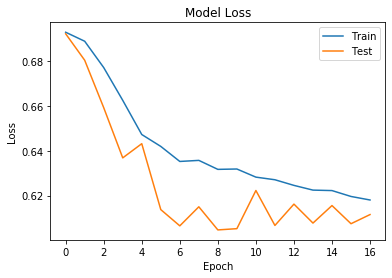

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upperright')
plt.show()

### Accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'lowerright'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


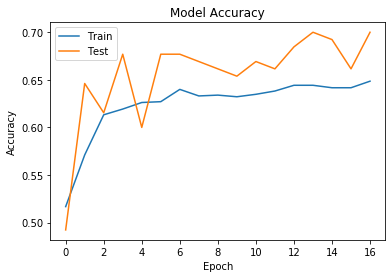

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'lowerright')
plt.show()

In [0]:
ANN_Model.predict_proba(X_test)

array([[0.70705247],
       [0.5005496 ],
       [0.7307775 ],
       [0.5002417 ],
       [0.7155159 ],
       [0.32282677],
       [0.32576507],
       [0.5489222 ],
       [0.36776966],
       [0.19536269],
       [0.5342355 ],
       [0.5317861 ],
       [0.5088488 ],
       [0.7739638 ],
       [0.4929006 ],
       [0.44512063],
       [0.5492856 ],
       [0.19890755],
       [0.45330682],
       [0.7351171 ],
       [0.68997335],
       [0.08618593],
       [0.5328963 ],
       [0.25748438],
       [0.40876177],
       [0.47259957],
       [0.18047401],
       [0.696216  ],
       [0.69859767],
       [0.36718705],
       [0.60692304],
       [0.24744561],
       [0.8113998 ],
       [0.3711073 ],
       [0.5006055 ],
       [0.39189273],
       [0.6508398 ],
       [0.31643128],
       [0.53699833],
       [0.61236346],
       [0.580691  ],
       [0.36923063],
       [0.6282209 ],
       [0.73603475],
       [0.5963594 ],
       [0.07985136],
       [0.31223893],
       [0.334

In [0]:
target_names= ['Loses','Wins']
print("Predicting winers")
t0 = time()
y_pred = np.where(ANN_Model.predict_proba(X_test) > 0.5, 1, 0)
print("done in {}s".format(time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

Predicting winers
done in 0.017824888229370117s
              precision    recall  f1-score   support

       Loses       0.79      0.59      0.68        69
        Wins       0.64      0.82      0.72        61

    accuracy                           0.70       130
   macro avg       0.71      0.71      0.70       130
weighted avg       0.72      0.70      0.70       130

[[41 28]
 [11 50]]


## Choosing the best model by comparing performance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


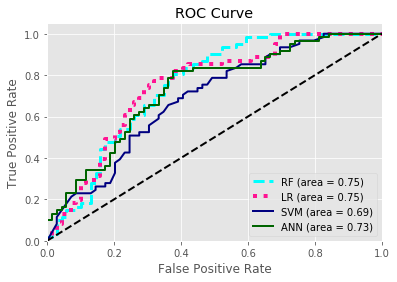

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Probabilities for each class for each classifier.

RFprobs = Model.predict_proba(X_test)[:, 1]
LRprobs = lr.predict_proba(X_test)[:, 1]
SVMprobs = Model2.predict_proba(X_test)[:, 1]
ANNprobs = ANN_Model.predict_proba(X_test)



fpr_Model, tpr_Model, _ = roc_curve(y_test, RFprobs)
roc_auc_Model = auc(fpr_Model, tpr_Model)

fpr_LR, tpr_LR, _ = roc_curve(y_test, LRprobs)
roc_auc_LR = auc(fpr_LR, tpr_LR)

fpr_svm, tpr_svm, _ = roc_curve(y_test, SVMprobs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_ANN, tpr_ANN, _ = roc_curve(y_test, ANNprobs)
roc_auc_ANN = auc(fpr_ANN, tpr_ANN)



plt.figure()
plt.plot(fpr_Model, tpr_Model, color='aqua', linestyle='--', linewidth=3,
         lw=2, label='RF (area = %0.2f)' % roc_auc_Model)
plt.plot(fpr_LR, tpr_LR, color='deeppink', linestyle=':', linewidth=4,
         lw=2, label='LR (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_svm, tpr_svm, color='navy',
         lw=2, label='SVM (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_ANN, tpr_ANN, color='darkgreen',
         lw=2, label='ANN (area = %0.2f)' % roc_auc_ANN)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Best Model is Logistic Regression and Random Forest

## Score System to see the best player

The last 8 rows correspond to the prediction games for task 2. Therefore (11772, 61) is all players playing vs all players

and 

(8,61) corresponds to the players in interest for prediction

In [0]:
uploaded = files.upload()
Data = pd.read_csv(io.StringIO(uploaded['evaluationset.csv'].decode('utf-8')))

Saving evaluationset.csv to evaluationset.csv


In [0]:
# Converting the home countries to binary with hot encode

Data = pd.get_dummies(Data, columns=["Home Player Country"])

Data = pd.get_dummies(Data, columns=["Away Player Country"])

columns = Data.columns




# Normalizing data


# Applying the minmax normalization.
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(Data.iloc[:,:])


x_scaled.shape

(11780, 66)

In [0]:
Data = pd.DataFrame(x_scaled)
Data.columns = columns[:]

Data.head()

,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home_Age,Home_Height,Home_Weight,Away_Age,Away_Height,Away_Weight,Home Player Country_Australia,Home Player Country_Bosnia and Herzegovina,Home Player Country_Brazil,Home Player Country_Cameroon,Home Player Country_Canada,Home Player Country_Croatia,Home Player Country_Democratic Republic of Congo,Home Player Country_Dominican Republic,Home Player Country_France,Home Player Country_Germany,Home Player Country_Greece,Home Player Country_Haiti,Home Player Country_Israel,Home Player Country_Latvia,Home Player Country_Lithuania,Home Player Country_Montenegro,Home Player Country_NBA,Home Player Country_New Zealand,Home Player Country_Poland,Home Player Country_Russia,Home Player Country_Serbia,Home Player Country_South Sudan,Home Player Country_Spain,Home Player Country_Switzerland,Home Player Country_Tunisia,Home Player Country_Turkey,Home Player Country_USA,Home Player Country_Ukraine,Away Player Country_Australia,Away Player Country_Bosnia and Herzegovina,Away Player Country_Brazil,Away Player Country_Cameroon,Away Player Country_Canada,Away Player Country_Croatia,Away Player Country_Democratic Republic of Congo,Away Player Country_Dominican Republic,Away Player Country_France,Away Player Country_Germany,Away Player Country_Greece,Away Player Country_Haiti,Away Player Country_Israel,Away Player Country_Latvia,Away Player Country_Lithuania,Away Player Country_Montenegro,Away Player Country_NBA,Away Player Country_New Zealand,Away Player Country_Poland,Away Player Country_Russia,Away Player Country_Serbia,Away Player Country_South Sudan,Away Player Country_Spain,Away Player Country_Switzerland,Away Player Country_Tunisia,Away Player Country_Turkey,Away Player Country_USA,Away Player Country_Ukraine
0,0.0,0.472222,0.500000,0.323232,0.666667,0.545455,0.545455,0.722222,0.545455,0.898990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.694444,0.363636,0.474747,0.666667,0.545455,0.545455,0.277778,0.818182,0.595960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.527778,0.545455,0.525253,0.666667,0.545455,0.545455,0.611111,0.454545,0.494949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.694444,0.454545,0.328283,0.666667,0.545455,0.545455,0.277778,0.636364,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.472222,0.409091,0.424242,0.666667,0.545455,0.545455,0.722222,0.727273,0.696970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Dropping columns that were not in the model:

Data = Data.drop(["Home Player Country_Israel",'Home Player Country_NBA','Home Player Country_Tunisia',
                  'Home Player Country_Turkey','Away Player Country_Turkey'], axis=1)

In [0]:
Data.Date = 1
Data.head()

,Date,Difference of Age: Home Player,Difference Height: Home Player,Difference Weight: Home Player,Home_Age,Home_Height,Home_Weight,Away_Age,Away_Height,Away_Weight,Home Player Country_Australia,Home Player Country_Bosnia and Herzegovina,Home Player Country_Brazil,Home Player Country_Cameroon,Home Player Country_Canada,Home Player Country_Croatia,Home Player Country_Democratic Republic of Congo,Home Player Country_Dominican Republic,Home Player Country_France,Home Player Country_Germany,Home Player Country_Greece,Home Player Country_Haiti,Home Player Country_Latvia,Home Player Country_Lithuania,Home Player Country_Montenegro,Home Player Country_New Zealand,Home Player Country_Poland,Home Player Country_Russia,Home Player Country_Serbia,Home Player Country_South Sudan,Home Player Country_Spain,Home Player Country_Switzerland,Home Player Country_USA,Home Player Country_Ukraine,Away Player Country_Australia,Away Player Country_Bosnia and Herzegovina,Away Player Country_Brazil,Away Player Country_Cameroon,Away Player Country_Canada,Away Player Country_Croatia,Away Player Country_Democratic Republic of Congo,Away Player Country_Dominican Republic,Away Player Country_France,Away Player Country_Germany,Away Player Country_Greece,Away Player Country_Haiti,Away Player Country_Israel,Away Player Country_Latvia,Away Player Country_Lithuania,Away Player Country_Montenegro,Away Player Country_NBA,Away Player Country_New Zealand,Away Player Country_Poland,Away Player Country_Russia,Away Player Country_Serbia,Away Player Country_South Sudan,Away Player Country_Spain,Away Player Country_Switzerland,Away Player Country_Tunisia,Away Player Country_USA,Away Player Country_Ukraine
0,1,0.472222,0.500000,0.323232,0.666667,0.545455,0.545455,0.722222,0.545455,0.898990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.694444,0.363636,0.474747,0.666667,0.545455,0.545455,0.277778,0.818182,0.595960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.527778,0.545455,0.525253,0.666667,0.545455,0.545455,0.611111,0.454545,0.494949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0.694444,0.454545,0.328283,0.666667,0.545455,0.545455,0.277778,0.636364,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.472222,0.409091,0.424242,0.666667,0.545455,0.545455,0.722222,0.727273,0.696970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
x = Data.to_numpy()

In [0]:
x.shape

(11780, 61)

### Predictions

In [0]:
prediction = lr.predict(x)

probability_predictions = lr.predict_proba(x)

In [0]:
probability_predictions[1]

array([0.50029388, 0.49970612])

In [0]:
Resultslr = pd.DataFrame()

Resultslr['prediction'] = lr.predict(x)
Resultslr['probability_predictions'] = lr.predict_proba(x)[:,1]

Resultslr.head()

,prediction,probability_predictions
0,0.0,0.499128
1,0.0,0.499706
2,1.0,0.500849
3,0.0,0.499823
4,0.0,0.499853


In [0]:
Results.to_csv('Resultslr.csv') 


In [0]:
files.download('Resultslr.csv')

## Prediction with NN

In [0]:
predictionANN = ANN_Model.predict(x)

probability_predictionsANN = ANN_Model.predict_proba(x)

In [0]:
probability_predictionsANN

array([[0.4695543 ],
       [0.687358  ],
       [0.61112934],
       ...,
       [0.70365816],
       [0.847671  ],
       [0.31609413]], dtype=float32)

In [0]:
ResultsANN = pd.DataFrame(probability_predictionsANN)



ResultsANN.head()

,0
0,0.469554
1,0.687358
2,0.611129
3,0.497904
4,0.672921


In [0]:
ResultsANN.to_csv('ResultsANN.csv') 

In [0]:
files.download('ResultsANN.csv')

## Prediction with RF

In [0]:
predictionRF = Model.predict(x)

probability_predictionsRF = Model.predict_proba(x)

probability_predictionsRF

array([[0.48275964, 0.51724036],
       [0.55998   , 0.44002   ],
       [0.44747375, 0.55252625],
       ...,
       [0.3948443 , 0.6051557 ],
       [0.39746025, 0.60253975],
       [0.56408444, 0.43591556]])

In [0]:
ResultsRF= pd.DataFrame(probability_predictionsRF).iloc[:,1]

ResultsRF.head()

0    0.517240
1    0.440020
2    0.552526
3    0.452823
4    0.442683
Name: 1, dtype: float64

In [0]:
ResultsRF.to_csv('ResultsRF.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Data Insights

In [4]:
uploaded = files.upload()
Data1 = pd.read_csv(io.StringIO(uploaded['exploratory1.csv'].decode('utf-8')))

Saving exploratory1.csv to exploratory1.csv


In [5]:
Data1.head()

,Date,Home,Away,Home Player,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Home Player Country,Away Player,Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs),Away Player Country,Home Player Win
0,17/10/17,CLE,BOS,Kevin Love,30,82,251,USA,Al Horford,32,82,245,Dominican Republic,0
1,17/10/17,GSW,HOU,Zaza Pachulia,34,83,270,Russia,Clint Capela,24,82,240,Switzerland,0
2,18/10/17,DET,CHA,Andre Drummond,25,83,279,USA,Dwight Howard,32,83,265,USA,0
3,18/10/17,IND,BKN,Myles Turner,22,83,250,USA,Timofey Mozgov,32,85,275,Russia,1
4,18/10/17,ORL,MIA,Nikola Vucevic,27,84,260,Montenegro,Hassan Whiteside,29,85,265,USA,0


In [8]:
Data1.describe()

,Home Player Age,Home Player Height (Inches),Home Player Weight (Lbs),Away Player Age,Away Player Height (Inches),Away Player Weight (Lbs),Home Player Win
count,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000
mean,27.546863,83.270333,251.864446,27.704105,83.274981,252.254067,0.505809
std,4.200767,1.459174,15.391613,4.125264,1.484645,15.940069,0.500160
min,20.000000,76.000000,191.000000,20.000000,76.000000,191.000000,0.000000
25%,24.000000,83.000000,240.000000,25.000000,83.000000,240.000000,0.000000
50%,27.000000,83.000000,250.000000,27.000000,83.000000,250.000000,1.000000
75%,30.000000,84.000000,265.000000,30.000000,84.000000,265.000000,1.000000
max,38.000000,87.000000,280.000000,38.000000,87.000000,290.000000,1.000000


## Distributions

In [0]:
d = Data1.to_numpy()

In [10]:
d.shape

(1291, 14)

In [0]:
d_num = Data1.select_dtypes(include=['float64','int64'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


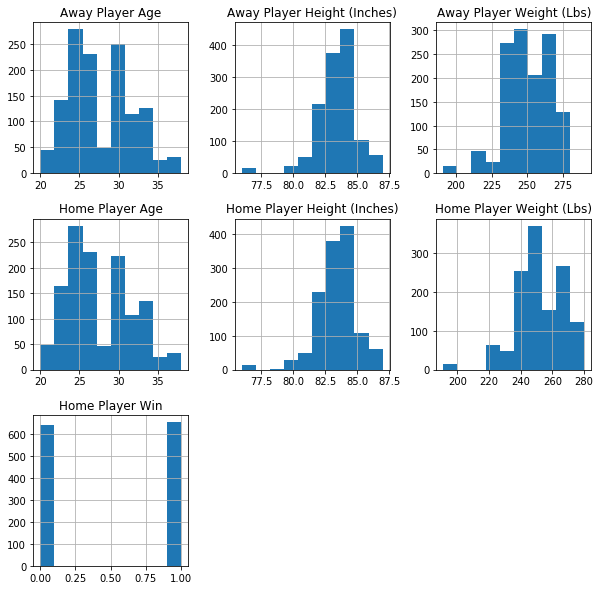

In [50]:
## distribution of diferent varoables

fig = plt.figure(figsize = (10,10))
ax = fig.gca()
d_num.hist(ax=ax)
plt.show()

In [0]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

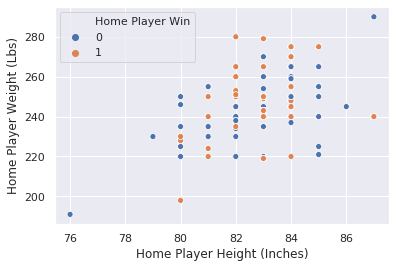

In [48]:

ax1 = sns.scatterplot(x="Home Player Height (Inches)", y="Home Player Weight (Lbs)",
                     hue="Home Player Win", sizes=(200, 200), data=Data)



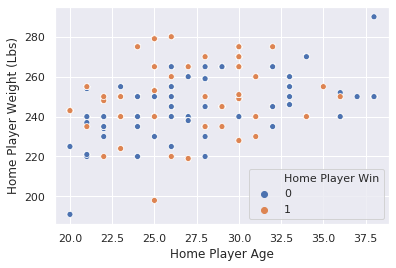

In [49]:
ax2 = sns.scatterplot(x="Home Player Age", y="Home Player Weight (Lbs)",
                     hue="Home Player Win", sizes=(200, 200), data=Data)


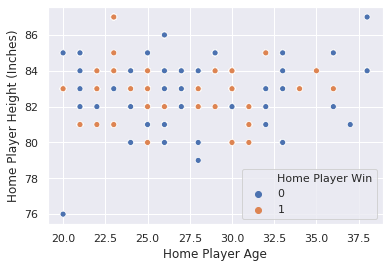

In [50]:
ax3 = sns.scatterplot(x="Home Player Age", y="Home Player Height (Inches)",
                     hue="Home Player Win", sizes=(200, 200), data=Data)